## Part 2: Classification and GradCam Visualization

### Model Initialization and Compilation

In this section, we initialize and compile three different segmentation models using the `segmentation_models` library. Each model is designed to segment the lung region in chest X-ray (CXR) images. We use different backbone architectures to compare their performance. The models are:
1. U-Net with InceptionResNetV2 backbone
2. Feature Pyramid Network (FPN) with EfficientNetB2 backbone
3. LinkNet with SEResNeXt50 backbone

#### Parameters:
- `input_shape`: Shape of the input images (256, 256, 1) indicating 256x256 pixels and 1 channel (grayscale).
- `classes`: Number of output classes for the segmentation task (1 class for lung region).
- `activation`: Activation function for the output layer ('sigmoid' for binary classification).
- `encoder_weights`: Pre-trained weights for the encoder part of the network (set to `None` to train from scratch).

#### Compilation:
- `optimizer`: Adam optimizer with a learning rate of 1e-4.
- `loss`: Custom dice coefficient loss function to handle class imbalance in medical images.
- `metrics`: Evaluation metrics including dice coefficient, binary accuracy, and Intersection over Union (IoU) score.

In [8]:
model = sm.Unet('inceptionresnetv2', classes=1, activation='sigmoid',input_shape=(256, 256, 1),encoder_weights=None)
model.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])

model.load_weights('/kaggle/input/models/inceptionresnetv2.weights.h5')

#model.evaluate(validation_vol,validation_seg)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1042 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [9]:
model1 = sm.FPN('efficientnetb2', classes=1, activation='sigmoid',input_shape=(256, 256, 1),encoder_weights=None)
model1.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model1.load_weights("/kaggle/input/models/efficientnetb2.weights.h5")
#model1.evaluate(validation_vol,validation_seg)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 678 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [10]:
model2 = sm.Linknet('seresnext50', classes=1, activation='sigmoid',input_shape=(256, 256, 1),encoder_weights=None)
model2.compile(optimizer=Adam(learning_rate=1e-4), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy',iou_score])
model2.load_weights("/kaggle/input/models/linkseresnext50.weights.h5")
#model2.evaluate(validation_vol,validation_seg)

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 1534 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


### Data Preprocessing and Segmentation

In this section, we preprocess and segment chest X-ray images for different classes of respiratory conditions. The segmented images will highlight the lung regions, facilitating further analysis.

#### Steps:
1. **Set Input and Output Paths**: Define paths for input images and output segmented images.
2. **Create Output Directory**: Ensure the output directory exists.
3. **Iterate through Classes**: Loop through each respiratory condition class.
4. **Load and Preprocess Images**: Load images, resize them, and normalize pixel values.
5. **Predict Segmentation**: Use the pre-trained models to predict lung regions.
6. **Post-process Segmentation**: Refine segmentation masks and overlay them on original images.
7. **Save Segmented Images**: Save the final segmented images in the output directory.

In [19]:
import os
import cv2
import numpy as np
from IPython.display import clear_output

input_base_path = '/kaggle/input/covid19-radiography-database/COVID-19_Radiography_Dataset/'
output_base_path = '/kaggle/working/output/'  # Change this to your desired output path

# Create the output folder if it doesn't exist
os.makedirs(output_base_path, exist_ok=True)

# List of classes or folders
classes = ['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']

# Iterate through each class
for class_name in classes:
    input_folder = os.path.join(input_base_path, class_name, 'images')
    output_folder = os.path.join(output_base_path, class_name, 'segmented')

    # Create the output class folder if it doesn't exist
    os.makedirs(output_folder, exist_ok=True)

    # List all image files in the input folder
    image_files = [f for f in os.listdir(input_folder) if f.endswith('.png') or f.endswith('.jpg')]

    # Iterate through each image
    for image_file in image_files:
        # Load the image
        image_path = os.path.join(input_folder, image_file)
        grayscale_image = cv2.imread(image_path, 0)  # Load image in grayscale
        grayscale_image = cv2.resize(grayscale_image, (256, 256), interpolation=cv2.INTER_NEAREST)
        grayscale_image = (grayscale_image - 127.0) / 127.0
        grayscale_image = grayscale_image.reshape(1, 256, 256, 1)
        
        pred1 = model.predict(grayscale_image)
        pred1 = pred1.reshape(256, 256, 1)
        
        pred2 = model1.predict(grayscale_image)
        pred2 = pred2.reshape(256, 256, 1)
        
        pred3 = model2.predict(grayscale_image)
        pred3 = pred3.reshape(256, 256, 1)
        
        
        combined_predictions = np.ones((256, 256), dtype=float)
        mask = np.ones((256, 256), dtype=float)
        min_col = 256
        max_col = 0
        min_row = 256
        max_row = 0
        segmentation_flag = 0
        grayscale_image = grayscale_image.reshape(256, 256, 1)
        
        for i in range(len(grayscale_image)):
            empty_count = 0
            for j in range(len(grayscale_image)):
                if pred1[i][j] >= 0.4 or pred2[i][j] >= 0.4 or pred3[i][j] >= 0.4:
                    combined_predictions[i][j] = grayscale_image[i][j]
                    mask[i][j] = 0
                    min_col = min(min_col, j)
                    max_col = max(max_col, j)
                    segmentation_flag = 1
                else:
                    empty_count += 1
            if empty_count == 256:
                if segmentation_flag == 0:
                    max_row = max(max_row, i)
                else:
                    min_row = min(min_row, i)

        if min_row < 140:
            min_row = 256
        if max_col < 140:
            max_col = 256

        combined_predictions = combined_predictions[max_row:min_row, min_col:max_col]
        if combined_predictions.size:
            combined_predictions = cv2.resize(combined_predictions, (256, 256), interpolation=cv2.INTER_NEAREST)

            # Overlay segmented regions on the original image
            original_image = cv2.imread(image_path)  # Load original image in BGR color format
            segmented_image = np.zeros_like(original_image, dtype=np.uint8)
            for i in range(256):
                for j in range(256):
                    if mask[i][j] == 0:
                        segmented_image[i][j] = original_image[i][j]

            # Save the segmented output
            output_path = os.path.join(output_folder, image_file.replace('.png', '_segmented.png'))
            cv2.imwrite(output_path, segmented_image)
            clear_output(wait=True)

print("Segmentation complete. Segmented images saved in the output folder.")


Segmentation complete. Segmented images saved in the output folder.


In [3]:
!pip install -U keras-cv-attention-models

  Obtaining dependency information for keras-cv-attention-models from https://files.pythonhosted.org/packages/ed/34/326174421f782fab59c96efcbbcfa2d4637e77243d5218888687e55ae54d/keras_cv_attention_models-1.4.1-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 kB 5.5 MB/s eta 0:00:00
  Obtaining dependency information for ftfy from https://files.pythonhosted.org/packages/f4/f0/21efef51304172736b823689aaf82f33dbc64f54e9b046b75f5212d5cee7/ftfy-6.2.0-py3-none-any.whl.metadata
  Obtaining dependency information for wcwidth<0.3.0,>=0.2.12 from https://files.pythonhosted.org/packages/fd/84/fd2ba7aafacbad3c4201d395674fc6348826569da3c0937e75505ead3528/wcwidth-0.2.13-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 796.3/796.3 kB 12.5 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.1 MB/s eta 0:00:00
  Attempting uninstall: wcwidth
    Found existing installation: wcwidth 0.2.6
    Uninstalling wcwidth-

### Data Loading and Preprocessing

This section covers loading and preprocessing segmented chest X-ray images. The images are resized and formatted to fit the input shape required for the model. Labels are assigned to each image based on the class they belong to.

#### Steps:
1. **Set Working Directory**: Change to the directory containing the segmented images.
2. **Define Input Shape**: Specify the input shape for the model.
3. **Load Segmented Data**: Load and preprocess segmented images for each class.
4. **Limit Per Class**: Set a maximum number of images per class to balance the dataset.
5. **Store Data and Labels**: Append the preprocessed images and their corresponding labels to lists.

In [4]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow import keras
from keras_cv_attention_models import coatnet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Set your working directory
working_directory = "/kaggle/input/hidata/"
os.chdir(working_directory)

# Define input shape for grayscale images
input_shape = (256, 256, 1)  # Adjust based on your segmented images

# Load segmented data
X_data = []
y_data = []
limit_per_class = 3000  # Set the limit per class

# List of classes or folders
classes = ['COVID', 'Normal', 'Viral Pneumonia']

for class_name in classes:
    segmented_folder = os.path.join(working_directory, 'output', class_name, 'segmented')

    # List all image files in the segmented folder
    segmented_files = [f for f in os.listdir(segmented_folder) if f.endswith('_segmented.png')]
    
    # Initialize count for the class
    limit = 0
    
    # Iterate through each segmented image
    for segmented_file in segmented_files:
        # Load the segmented image in grayscale
        segmented_path = os.path.join(segmented_folder, segmented_file)
        img = cv2.imread(segmented_path, 0)  # The '0' flag loads images in grayscale

        # Resize image to input_shape if necessary
        img = cv2.resize(img, (256, 256))

        # Expand dimensions to fit input_shape (256, 256, 1)
        img = np.expand_dims(img, axis=-1)

        # Check if the limit for the class has been reached
        if limit < limit_per_class:
            # Append the image to X_data
            X_data.append(img)

            # Append the label to y_data (assuming 0-indexed classes)
            y_data.append(classes.index(class_name))
            
            # Increment the count for the class
            limit += 1

# Convert lists to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

In [5]:
len(X_data)

7345

### Data Splitting and Augmentation

In this section, we split the dataset into training, validation, and test sets. We also create data generators with augmentation to enhance the training process and prevent overfitting.

#### Steps:
1. **Split Dataset**: Divide the dataset into training, validation, and test sets.
2. **Create Data Generators**: Use `ImageDataGenerator` to apply augmentation techniques to the training set and rescale pixel values for all sets.
3. **Define Batch Size**: Set the batch size for the data generators.

In [6]:
# Split the dataset into train, test, and validation sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Create data generators with augmentation for the train set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)  # No augmentation for validation and test sets

# Define batch size
batch_size = 32

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=batch_size)
val_generator = val_datagen.flow(X_val, y_val, batch_size=batch_size)
test_generator = val_datagen.flow(X_test, y_test, batch_size=batch_size)

### Model Definition and Training

In this section, we define and train the CoAtNet model for the classification of respiratory conditions from segmented chest X-ray images. CoAtNet is a hybrid model that combines the strengths of convolutional neural networks (CNNs) and attention mechanisms, providing a powerful and efficient architecture for image classification tasks.

#### CoAtNet Overview:
CoAtNet, or Convolutional-Attention Network, leverages both convolutional operations and self-attention mechanisms to enhance feature extraction and representation. It is designed to capture local patterns using convolutions and global dependencies using attention, making it well-suited for medical imaging tasks like diagnosing respiratory diseases from chest X-rays.

#### Model Architecture:
1. **Base Model**: CoAtNet0 initialized with the specified input shape.
2. **Flattening Layer**: Global average pooling to reduce the dimensions.
3. **Fully Connected Layers**: Two dense layers with dropout for regularization.
4. **Output Layer**: Softmax layer for multi-class classification.

#### Compilation:
- **Loss Function**: Sparse categorical cross-entropy.
- **Optimizer**: Adam optimizer with a learning rate of 1e-3.
- **Metrics**: Sparse categorical accuracy.

#### Training:
- **Epochs**: Set to 50 (adjustable).
- **Data Generators**: Use the previously defined training and validation generators.

We can experiment with other models and architectures like ResNet50 etc. to further improve performance and robustness. This approach allows us to explore various methods to enhance the accuracy and reliability of the diagnosis.

In [7]:
from keras_cv_attention_models import coatnet
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

model = coatnet.CoAtNet0(input_shape = (256, 256, 1),num_classes=0)

flatten = tf.keras.layers.GlobalAveragePooling2D()(model.output)
drop_out = tf.keras.layers.Dropout(0.25)(flatten)
dense = tf.keras.layers.Dense(2048, activation = "relu")(drop_out)
drop_out = tf.keras.layers.Dropout(0.3)(flatten)
dense = tf.keras.layers.Dense(1024, activation = "relu")(drop_out)
prediction = tf.keras.layers.Dense(3, activation = "softmax", name = "prediction")(dense)
model = tf.keras.Model(model.input, prediction)

# Compile the model
loss = tf.keras.losses.sparse_categorical_crossentropy
opt = tf.keras.optimizers.Adam(1e-3)
metric = [tf.keras.metrics.sparse_categorical_accuracy]
model.compile(loss=loss, optimizer=opt, metrics=metric)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7, min_lr=1e-7, verbose=1)
checkpoint = ModelCheckpoint('/kaggle/working/best_model.h5', monitor='val_sparse_categorical_accuracy', mode='max', save_best_only=True, verbose=1)

# Train the model with callbacks
epochs = 50  # Adjust as needed
hist = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[reduce_lr, checkpoint]
)

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}')


93747824/93747824 [==============================] - 0s 0us/step
>>>> Load pretrained from: /root/.keras/models/coatnet0_224_imagenet.h5
>>>> Reload mismatched weights: 224 -> (256, 256)
>>>> Reload layer: stack_3_block_1_mhsa_pos_emb
>>>> Reload layer: stack_3_block_2_mhsa_pos_emb
>>>> Reload layer: stack_3_block_3_mhsa_pos_emb
>>>> Reload layer: stack_3_block_4_mhsa_pos_emb
>>>> Reload layer: stack_3_block_5_mhsa_pos_emb
>>>> Reload layer: stack_4_block_1_mhsa_pos_emb
>>>> Reload layer: stack_4_block_2_mhsa_pos_emb
Epoch 1/50
147/147 [==============================] - ETA: 0s - loss: 1.6293 - sparse_categorical_accuracy: 0.4381
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.50850, saving model to /kaggle/working/best_model.h5


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


147/147 [==============================] - 132s 657ms/step - loss: 1.6293 - sparse_categorical_accuracy: 0.4381 - val_loss: 0.9114 - val_sparse_categorical_accuracy: 0.5085 - lr: 0.0010
Epoch 2/50
147/147 [==============================] - ETA: 0s - loss: 0.7444 - sparse_categorical_accuracy: 0.6483
Epoch 2: val_sparse_categorical_accuracy improved from 0.50850 to 0.66752, saving model to /kaggle/working/best_model.h5
147/147 [==============================] - 91s 621ms/step - loss: 0.7444 - sparse_categorical_accuracy: 0.6483 - val_loss: 0.6735 - val_sparse_categorical_accuracy: 0.6675 - lr: 0.0010
Epoch 3/50
147/147 [==============================] - ETA: 0s - loss: 0.6012 - sparse_categorical_accuracy: 0.7213
Epoch 3: val_sparse_categorical_accuracy improved from 0.66752 to 0.78997, saving model to /kaggle/working/best_model.h5
147/147 [==============================] - 91s 621ms/step - loss: 0.6012 - sparse_categorical_accuracy: 0.7213 - val_loss: 0.5008 - val_sparse_categorical_ac

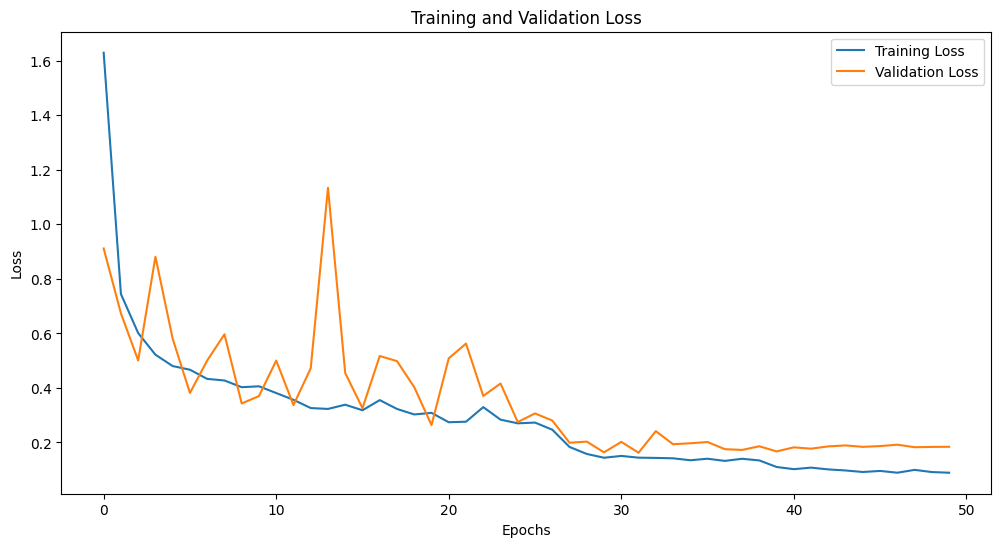

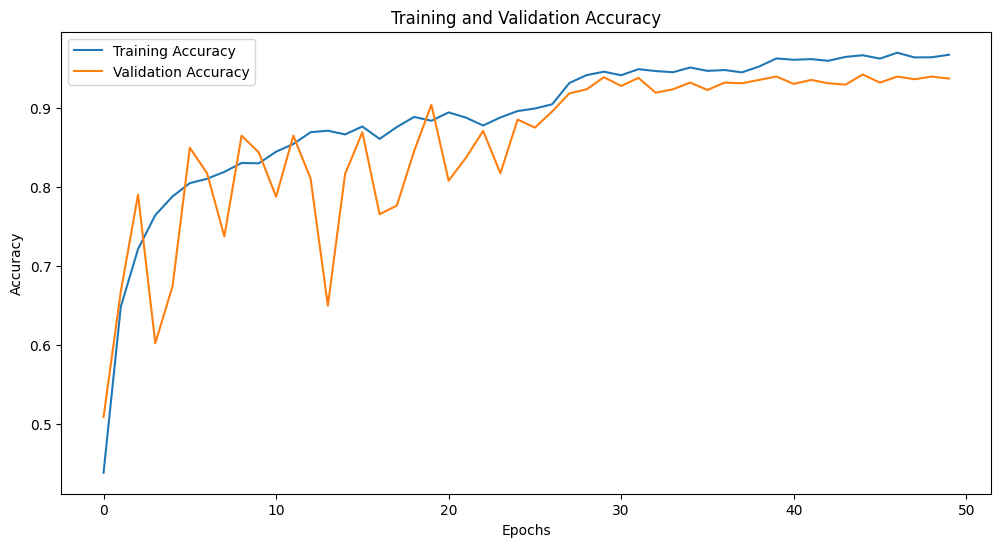

In [9]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(12, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.plot(hist.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))
plt.plot(hist.history['sparse_categorical_accuracy'], label='Training Accuracy')
plt.plot(hist.history['val_sparse_categorical_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [11]:
from tensorflow.keras.models import load_model

model = load_model("/kaggle/input/models/best_model.h5")

### Image Preprocessing and Visualization

In this section, we prepare the chest X-ray images for visualization and further analysis. We save the preprocessed image and set up the path for the saved image. This can be used later for visualization tasks such as Grad-CAM to understand model predictions better.

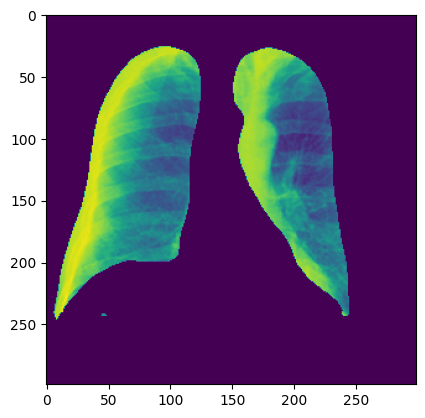

In [12]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from IPython.display import Image, display
import matplotlib.cm as cm

img_x = cv2.imread("/kaggle/input/hidata/output/COVID/segmented/COVID-1005_segmented.png",0)

plt.imshow(img_x)

In [13]:
import matplotlib
img_size = (256, 256)

last_conv_layer_name = "stack_4_block_2_ffn_2_conv"
matplotlib.image.imsave("/kaggle/working/hi.jpg", img_x)

img_path = "/kaggle/working/hi.jpg"

### Grad-CAM Visualization

This section demonstrates how to generate and visualize Grad-CAM heatmaps for the chest X-ray images using the trained model. Grad-CAM helps in understanding which parts of the image contribute the most to the model's prediction.

#### Steps:
1. **Image Preprocessing**:
   - Load and preprocess the image.
   - Convert the image to grayscale if needed.
   - Normalize the image.

2. **Grad-CAM Heatmap Generation**:
   - Define a function to create a Grad-CAM heatmap.
   - Use Gradient Tape to compute the gradients of the target class with respect to the last convolutional layer's output.
   - Generate the heatmap by pooling the gradients.

3. **Display Heatmap**:
   - Visualize the Grad-CAM heatmap to highlight the regions of interest in the input image.

1/1 [==============================] - 2s 2s/step


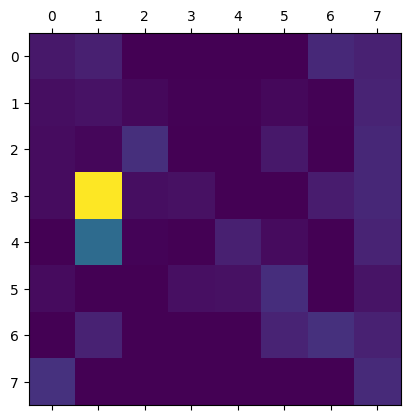

In [14]:
def get_img_array(img_path, size):
    # Load the image in grayscale
    img = keras.preprocessing.image.load_img(img_path, target_size=size, color_mode='grayscale')
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img


def convert_to_grayscale(img_array):
    # Assuming img_array is in shape (1, height, width, 3) and RGB format
    # Convert RGB to grayscale by taking the average across the color channels
    grayscale_img_array = tf.reduce_mean(img_array, axis=-1, keepdims=True)
    return grayscale_img_array

def preprocess_input(x):
    # Custom preprocessing for grayscale (normalize)
    return x / 255.0

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

img_array = get_img_array(img_path, size=img_size)
img_array = preprocess_input(img_array)

# Load the model
#model = load_model("coat0-11.hdf5")
model.layers[-1].activation = None  # Remove softmax for prediction

# Prediction
preds = model.predict(img_array)

# Generate Grad-CAM heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name="stack_4_block_2_ffn_2_conv")
heatmap1 = heatmap

# Display heatmap
plt.matshow(heatmap)
plt.show()

### Thresholding and Visualizing the Grad-CAM Heatmap

In this section, we apply a threshold to the Grad-CAM heatmap to highlight the most significant regions and then visualize the thresholded heatmap.


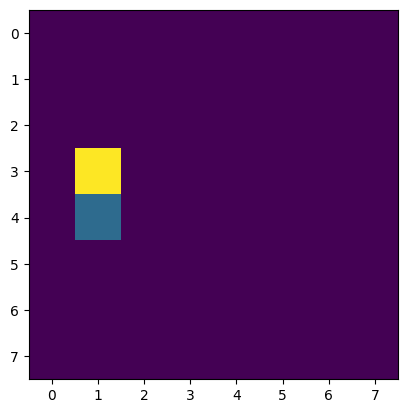

In [15]:
for i in range(8):
    for j in range(8):
        if heatmap1[i][j]>0.3:
            pass
        else:
            heatmap1[i][j]=  0
plt.imshow(heatmap1)

### Generating and Saving the Superimposed Grad-CAM Image

This section explains how to create a superimposed image by combining the Grad-CAM heatmap with the original chest X-ray image. The resulting image helps in visualizing the regions of the image that the model focuses on for making predictions.

#### Steps:
1. **Load Original Image**: Load the original grayscale image.
2. **Rescale Heatmap**: Convert the heatmap values to the range 0-255.
3. **Colorize Heatmap**: Use the jet colormap to convert the heatmap to an RGB image.
4. **Superimpose Heatmap**: Combine the colorized heatmap with the original image using a specified alpha value.
5. **Save Superimposed Image**: Save the resulting superimposed image to the specified path.

In [17]:
cam_path="/kaggle/working/coatpneu2.jpg" #required image
alpha=1
# Load the original image
img = cv2.imread(img_path,0)
cv2.imwrite(img_path,img)
img = keras.preprocessing.image.load_img(img_path)
img = keras.preprocessing.image.img_to_array(img)

heatmap = np.uint8(255 * heatmap1)

# Use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# Use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

target_color = np.array([0, 0, 127]) / 255.0
mask = np.all(np.isclose(jet_heatmap, target_color, atol=1/255), axis=-1)  # Tolerance for color matching

    # Set to black wherever the condition is met
#jet_heatmap[mask] = [0, 0, 0]


# Create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)


img = cv2.imread(img_path)


superimposed_img = jet_heatmap * alpha + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
superimposed_img.save(cam_path)

/tmp/ipykernel_47/716569701.py:12: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


### Displaying the Superimposed Grad-CAM Image

In this section, we display the superimposed Grad-CAM image to visualize the regions of the chest X-ray that are most relevant to the model's predictions. This is done by converting the image from BGR to RGB format and using Matplotlib for visualization.

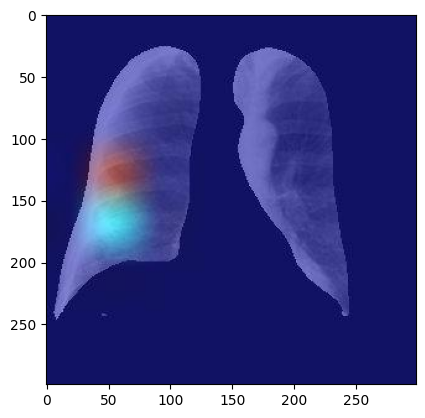

In [18]:
img = cv2.imread(cam_path)
b, g, r = cv2.split(img)
img = cv2.merge([r, g, b])
plt.imshow(img,cmap="gray")